# Setting Up

We first import the necessary libraries and modules.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm

from math import ceil
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

%matplotlib inline
%load_ext tensorboard

Segmentation Models: using `tf.keras` framework.


In [2]:
tf.__version__

'2.1.0'

Now, we set up the path to our Dataset images, the Backbone for the `U-Net` model and the Training/Validation split fraction.

In [3]:
DATA_PATH = "images/img_align_celeba"
BACKBONE = 'inceptionresnetv2'
VAL_SPLIT = 0.01

In [4]:
DATA_DIR = os.path.dirname(DATA_PATH)

# Looking at the Images

In [5]:
filenames = os.listdir(DATA_PATH)
n_imgs = len(filenames)
print("Total Number of Images: ", n_imgs)

Total Number of Images:  202599


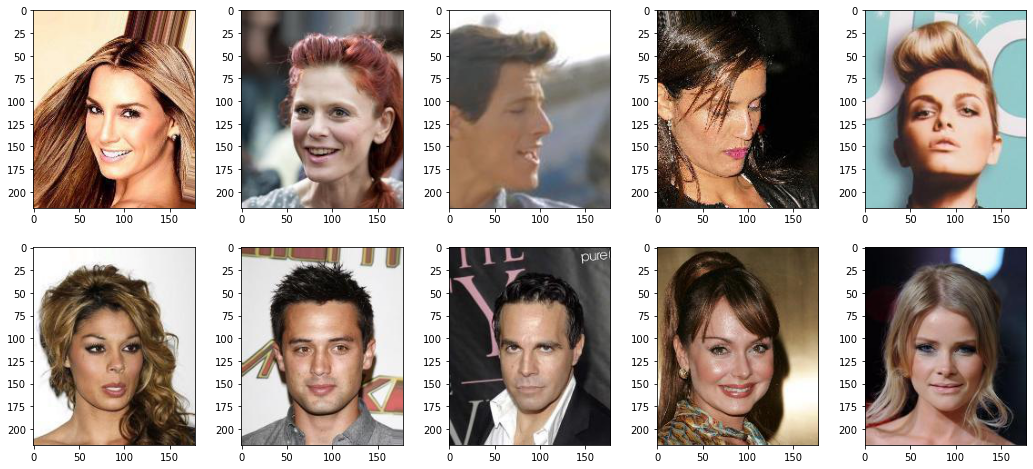

In [6]:
fig = plt.figure(figsize = (18,8))
for i in range(10):
    img = plt.imread(os.path.join(DATA_PATH, filenames[i]))
    plt.subplot(2,5,i+1)
    plt.imshow(img)   

In [7]:
n_valid_imgs = int(n_imgs * VAL_SPLIT)
n_train_imgs = n_imgs - n_valid_imgs
print("Number of Training Images: ", n_train_imgs)
print("Number of Validation Images: ", n_valid_imgs)

Number of Training Images:  200574
Number of Validation Images:  2025


# **Modelling the Generator**

Now, we create the U-Net based generator. To learn more about U-Net, check [this paper](https://arxiv.org/pdf/1505.04597.pdf) by *Olaf Ronneberger*, *Philipp Fischer*, and *Thomas Brox*.

For our task, we wanted to use a U-Net model whose encoder has been trained on the ImageNet dataset. For this, we used the awesome [Segmentation Model](https://github.com/qubvel/segmentation_models) library. In the Decoder block, we use `Upsampling` layers instead of `Transposed Convolutions` . We also attach the preprocessing function at the beginning so that we don't have to manually call it everytime we pass a batch of images to the generator.

In [8]:
preprocess_input = sm.get_preprocessing(BACKBONE)  

In [9]:
def create_generator(img_sz):
    unet = sm.Unet(backbone_name=BACKBONE, 
                    input_shape=(img_sz, img_sz, 3),
                    classes=3,
                    activation='linear',
                    weights=None,
                    encoder_weights='imagenet',                        
                    encoder_freeze=True,                    
                    encoder_features='default', 
                    decoder_block_type='upsampling', 
                    decoder_filters=(256, 128, 64, 32, 16), 
                    decoder_use_batchnorm=True)
    
    inp = tf.keras.layers.Input((img_sz,img_sz,3))
    x = preprocess_input(inp)
    x = unet(x)
    out = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x,0,255))(x)
    
    generator = Model(inp,out) 
    plot_model(generator, 
               to_file='generator-{0}x{0}.png'.format(img_sz), 
               show_shapes=True, 
               show_layer_names=True,
               expand_nested=True);
    print("Input: ", generator.inputs)
    print("Output: ", generator.outputs)
    print()  
    generator.summary()
    return generator

# **Modelling the Feature Comparator**

To make the generator learn better about the input images and its features, we are going to use a model that has been pretrained on the `ImageNet` dataset as our Feature vector Comparator. For our task, a `VGG16` based model would suffice. Since our main aim is to make the generator get a better sense of what features are important and how to recreate them, we are going to compare the Feature vectors of the generated image and the actual image, when they are passed through a VGG16 model. Here, we compare only the Feature vectors from the 5 Pooling layers at the end of each block. 

This approach has been heavily inspired by the wonderful paper [Perceptual Losses for Real-Time Style Transfer
and Super-Resolution](https://arxiv.org/pdf/1603.08155.pdf) by *Justin Johnson*, *Alexandre Alahi* and *Li Fei-Fei*, and *Jeremy Howard's* [Fastai](https://www.fast.ai/) course [Practical Deep Learning for Coders](https://course.fast.ai/).


In [10]:
def create_feat_comp(img_sz):
    vgg16 = tf.keras.applications.VGG16(include_top=False, 
                                        weights="imagenet", 
                                        input_shape=(img_sz,img_sz,3))
    vgg16.trainable = False
    pool_layers = [l for l in vgg16.layers if "pool" in l.name]  
    
    feat_comp = Model(inputs=vgg16.input, outputs=[l.output for l in pool_layers])    
    plot_model(feat_comp, 
               to_file='feat_comp-{0}x{0}.png'.format(img_sz), 
               show_shapes=True, 
               show_layer_names=True,
               expand_nested=True);
    print("Input: ", feat_comp.inputs)
    print("Output: ", feat_comp.outputs)
    print()
    feat_comp.summary()      
    return feat_comp

# **Crappifying**

This is our 'Crappify' function, where we add random sized black patches to the images within a predefined border.

In [11]:
def crappify(real_imgs):    
    patched_imgs = np.copy(real_imgs)    
    
    # We choose a boundary within which we are going to apply the Black Patches.
    img_sz = real_imgs.shape[1]
    boundary = int(img_sz/10)    
    r1 = 0.1*img_sz         # Minimum size of patch across an axis.
    r2 = 0.25*img_sz         # Maximum size of patch across an axis.
    r = (boundary, img_sz-r2-boundary)  
    
    # Adding Black Patches
    x1 = np.random.randint(r[0], r[1])
    y1 = np.random.randint(r[0], r[1])         # (x1,y1) --> Top left corner of Patch 
    x2 = np.random.randint(r1,r2)              
    y2 = np.random.randint(r1,r2)              # (x2,y2) --> Height and Width of Patch
    patched_imgs[:,x1:x1+x2, y1:y1+y2,:] = 0
    
    return patched_imgs

# Creating the DataGenerators

Now, we need to define the Training and Validation Generators that will read images from the disk and yield batches of Patched and Actual Images. 

We use the Keras `ImageDataGenerator` to apply various augmentations to images in the Training set, and then rescale them to the target size (`96`/`128`/`160`). We do not apply any augmentation on the Validation set images; only rescale them to the proper size. Our custom Generators simply uses these datagenerators to get batches of Actual images, and passes them through the `crappify` function to get batches of Patched images that can be fed into the model.

In [12]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            zoom_range=[0.85, 1.15],
                                                            horizontal_flip=True,
                                                            vertical_flip=False,
                                                            fill_mode='nearest',
                                                            data_format='channels_last',
                                                            brightness_range=[0.8, 1.2],
                                                            validation_split=VAL_SPLIT)

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=VAL_SPLIT)

In [13]:
# Iterates through the ImageDataGenerator yielding batches of Patched Images and Actual Images.
def iterate_and_distort(gen):
    while True:
        real_imgs = next(gen)
        patched_imgs = crappify(real_imgs)
        yield (patched_imgs, real_imgs)
        
# Creates the ImageDataGenerator and returns Custom generators that yield (Patched Images,Actual Images).
def custom_generators(img_sz,bs):
    train_generator = train_gen.flow_from_directory(DATA_DIR, 
                                                    target_size = (img_sz, img_sz), 
                                                    color_mode = 'rgb', 
                                                    classes = None, 
                                                    class_mode = None, 
                                                    batch_size = bs, 
                                                    seed = None,
                                                    subset = 'training',
                                                    shuffle = True) 
    
    valid_generator = valid_gen.flow_from_directory(DATA_DIR, 
                                                    target_size = (img_sz, img_sz), 
                                                    color_mode = 'rgb', 
                                                    classes = None, 
                                                    class_mode = None, 
                                                    batch_size = bs, 
                                                    seed = None,
                                                    subset = 'validation',
                                                    shuffle = True)
    custom_train_gen = iterate_and_distort(train_generator)
    custom_valid_gen = iterate_and_distort(valid_generator)
    
    return custom_train_gen, custom_valid_gen

# Looking at the Crappified Images

In [14]:
def actual_vs_crappified(img_sz,bs):
    custom_train_gen, _ = custom_generators(img_sz,bs)
    patched_imgs, real_imgs = next(custom_train_gen)
 
    fig = plt.figure(figsize = (18,8))
    for i in range(bs):
        plt.subplot(2, bs, i+1)
        plt.imshow(real_imgs[i].astype(int))        
        plt.subplot(2, bs, (i+1)+bs)
        plt.imshow(patched_imgs[i].astype(int))
    plt.show()  

Found 200574 images belonging to 1 classes.
Found 2025 images belonging to 1 classes.


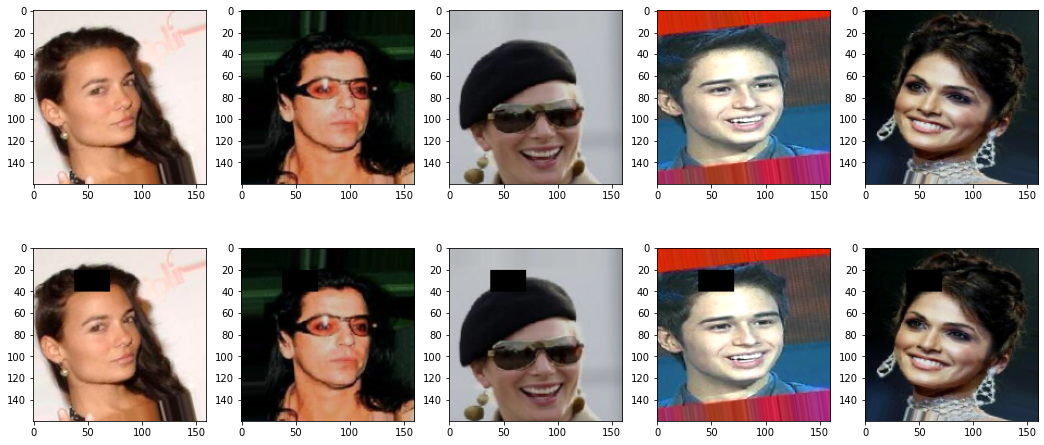

In [15]:
actual_vs_crappified(img_sz=160, bs=5)

# **The Loss Function**

We calculate the loss based on three metrics:-

    1) Pixel Loss --> The mean absolute difference between the Pixel values of the Generated Image and the Actual Image.
    2) Feature Loss --> The mean absolute difference between the Feature Vectors from the 5 Pooling layers when the 
                        Generated and Actual Image are passed through the VGG16 model. 
    3) Style Loss --> The mean absolute difference between the Gram Matrices of the output of the 5 Pooling layers when the 
                      Generated and Actual Image are passed through the VGG16 model.
    
To calculate these differences, we use `MeanAbsoluteError`. We then sum up these three losses, and return the result as the `Total Loss`.


In [16]:
abs_loss = tf.keras.losses.MeanAbsoluteError()  

In [17]:
def get_feat_loss(y, yhat):            # y.shape = yhat.shape = (b,h,w,c)            
    loss = abs_loss(y, yhat)           # = |y-yhat| / (b*h*w*c)
    return loss    

def gram_matrix(a):
    g = tf.linalg.einsum('bhwc,bhwd->bcd', a, a)
    return g

def get_style_loss(y, yhat):
    b,h,w,c = y.shape    
    y_gram = gram_matrix(y)    
    yhat_gram = gram_matrix(yhat)              # y_gram.shape = yhat_gram.shape = (b,c,c)
    
    loss = abs_loss(y_gram, yhat_gram)         # = |y_gram-yhat_gram| / (b*c*c)
    loss /= (h*h*w*w)                          # = |y_gram-yhat_gram| / (b*c*c*h*h*w*w)    
    return loss

In [18]:
# real_imgs_batch = Tensor of Batch of Actual Images from the Dataset.
# gen_imgs_batch = Tensor of Batch of Images generated by the Generator. 

def get_total_loss(real_imgs_batch, gen_imgs_batch): 
    pixel_loss = abs_loss(real_imgs_batch, gen_imgs_batch)
  
    real_imgs_feats = feat_comp(real_imgs_batch)
    gen_imgs_feats = feat_comp(gen_imgs_batch)    
    n = len(real_imgs_feats)
    feat_loss = 0
    style_loss = 0
    
    for (y,yhat) in zip(real_imgs_feats, gen_imgs_feats):        
        # Giving the feature loss and style loss from each layer an equal weight of 1/n.
        feat_loss += (1/n) * get_feat_loss(y,yhat)
        style_loss += (1/n) * get_style_loss(y,yhat)    

    total_loss = pixel_loss + feat_loss + style_loss 
    return total_loss   

# Creating the Model Checkpoint Callback

We create a `Callback` to save the model `weights` at the end of every `epoch`.

In [19]:
ckpts_path = os.path.join("training_checkpoints","{epoch:03d}-{loss:.3f}-{val_loss:.3f}") 
ckpt_dir = os.path.dirname(ckpts_path)

model_ckpt = tf.keras.callbacks.ModelCheckpoint(ckpts_path, 
                                                monitor='val_loss', 
                                                verbose=0,
                                                save_best_only=False,
                                                save_weights_only=True, 
                                                mode='auto', 
                                                save_freq='epoch')

# Training on 96x96 Images

We first train the model on `96x96` images. We will then use the learned weights, and train the model on `128x128 images`, and finally on `160x160` images. This technique of using smaller images at the beginning, taking the learned weights and then finetuning them over larger images is called `Progressive Resizing`. This is a common technqiue that *Jeremy Howard* uses in his Fastai course linked above.

## Setting the Image and Batch sizes

We set the `image_size` to `96`, and choose an appropriate `batch_size` that fits in our VRAM. Here, it's `64`.

In [20]:
img_sz = 96
bs = 64

## Initializing the DataGenerators

In [21]:
custom_train_gen, custom_valid_gen = custom_generators(img_sz,bs)

Found 200574 images belonging to 1 classes.
Found 2025 images belonging to 1 classes.


## Intitializing the Models

### Generator

In [22]:
generator = create_generator(img_sz)

Input:  [<tf.Tensor 'input_2:0' shape=(None, 96, 96, 3) dtype=float32>]
Output:  [<tf.Tensor 'lambda/Identity:0' shape=(None, 96, 96, 3) dtype=float32>]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 96, 96, 3)]       0         
_________________________________________________________________
model (Model)                (None, 96, 96, 3)         62061843  
_________________________________________________________________
lambda (Lambda)              (None, 96, 96, 3)         0         
Total params: 62,061,843
Trainable params: 7,753,395
Non-trainable params: 54,308,448
_________________

### Feature Comparator

In [23]:
feat_comp = create_feat_comp(img_sz)

Input:  [<tf.Tensor 'input_3:0' shape=(None, 96, 96, 3) dtype=float32>]
Output:  [<tf.Tensor 'block1_pool/Identity:0' shape=(None, 48, 48, 64) dtype=float32>, <tf.Tensor 'block2_pool/Identity:0' shape=(None, 24, 24, 128) dtype=float32>, <tf.Tensor 'block3_pool/Identity:0' shape=(None, 12, 12, 256) dtype=float32>, <tf.Tensor 'block4_pool/Identity:0' shape=(None, 6, 6, 512) dtype=float32>, <tf.Tensor 'block5_pool/Identity:0' shape=(None, 3, 3, 512) dtype=float32>]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_____________________________________________________

### Compiling the Model

We use `Adam` as the optimizer with a `learning_rate` of `1e-1`. Then, we compile the model.

In [24]:
generator.compile(optimizer = tf.keras.optimizers.Adam(1e-1), 
                  loss = get_total_loss, 
                  experimental_run_tf_function = False)

### Training the Model

Change the `intial_epoch` to the total number of `epochs` that you have ran yet, everytime you call `fit()` and adjust `epochs` accordingly. 

In [25]:
hist1 = generator.fit(custom_train_gen, 
                      epochs = 1, 
                      initial_epoch = 0, 
                      steps_per_epoch = ceil(n_train_imgs/bs),
                      validation_data = custom_valid_gen, 
                      validation_steps = ceil(n_valid_imgs/bs), 
                      callbacks = [model_ckpt])

3134/3134 [==============================] - 3731s 1s/step - loss: 119.7874 - val_loss: 222.8965


## FineTuning

We now move on to finetuning the model. Here, we unfreeze the model, recompile it and start training again.

### Unfreezing the Entire Model

In [26]:
generator.trainable = True

### Compiling the Entire Model

We set the `learning_rate` as `5e-2`.

In [27]:
generator.compile(optimizer = tf.keras.optimizers.Adam(5e-2), 
                  loss = get_total_loss, 
                  experimental_run_tf_function = False)

### Loading the Latest Weights

In [28]:
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
print(latest_ckpt)

training_checkpoints\001-119.788-222.897


In [29]:
generator.load_weights(latest_ckpt)

### Training the Entire Model

Change the `intial_epoch` to the total number of 'epochs' that you have ran yet, everytime you call `fit()` and adjust `epochs` accordingly.  

In [30]:
hist2 = generator.fit(custom_train_gen, 
                      epochs = 3, 
                      initial_epoch = 1, 
                      steps_per_epoch = ceil(n_train_imgs/bs),
                      validation_data = custom_valid_gen, 
                      validation_steps = ceil(n_valid_imgs/bs),
                      callbacks = [model_ckpt])

Epoch 2/3
3134/3134 [==============================] - 1464s 467ms/step - loss: 111.0577 - val_loss: 139.0039
Epoch 3/3
3134/3134 [==============================] - 1413s 451ms/step - loss: 79.1861 - val_loss: 87.9553


# Training on 128x128 Images

We'll now train on `128x128` images following the practice of `Progressive Resizing`. As a result, we'll reduce the `batch_size` and change `image_size` to `128`.

## Setting the Image and Batch sizes

We set the `image_size` to `128`, and `batch_size` to `32`.

In [31]:
img_sz = 128
bs = 32

## Re-Initializing the DataGenerators

We need to reinitialize the DataGenerators with the new `img_sz` of `128x128`.

In [32]:
custom_train_gen, custom_valid_gen = custom_generators(img_sz,bs)

Found 200574 images belonging to 1 classes.
Found 2025 images belonging to 1 classes.


## Re-Initializing the Models

Previously while finetuning, we had to unfreeze the entire generator. However, now, we'll need to train only the decoder (by keeping the encoder frozen), and later finetune the entire model again. Also, the shape of the `input` to the models are different (`128x128` rather than `96x96`).

### Generator

In [33]:
generator = create_generator(img_sz)

Input:  [<tf.Tensor 'input_5:0' shape=(None, 128, 128, 3) dtype=float32>]
Output:  [<tf.Tensor 'lambda_1/Identity:0' shape=(None, 128, 128, 3) dtype=float32>]

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv_1 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_sub_1 (TensorFlo [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_3 (Model)              (None, 128, 128, 3)       62061843  
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
Total params: 62,061,843
Trainable params: 7,753,395
Non-trainable params: 54,308,448
___________

### Feature Comparator

In [34]:
feat_comp = create_feat_comp(img_sz)

Input:  [<tf.Tensor 'input_6:0' shape=(None, 128, 128, 3) dtype=float32>]
Output:  [<tf.Tensor 'block1_pool_1/Identity:0' shape=(None, 64, 64, 64) dtype=float32>, <tf.Tensor 'block2_pool_1/Identity:0' shape=(None, 32, 32, 128) dtype=float32>, <tf.Tensor 'block3_pool_1/Identity:0' shape=(None, 16, 16, 256) dtype=float32>, <tf.Tensor 'block4_pool_1/Identity:0' shape=(None, 8, 8, 512) dtype=float32>, <tf.Tensor 'block5_pool_1/Identity:0' shape=(None, 4, 4, 512) dtype=float32>]

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________

### Compiling the Model

We set the `learning_rate` as `1e-2`.

In [35]:
generator.compile(optimizer = tf.keras.optimizers.Adam(1e-2), 
                  loss = get_total_loss, 
                  experimental_run_tf_function = False)

### Loading the Latest Weights

In [36]:
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
print(latest_ckpt)

training_checkpoints\003-79.186-87.955


In [37]:
generator.load_weights(latest_ckpt)

### Training the Model

Change the `intial_epoch` to the total number of 'epochs' that you have ran yet, everytime you call `fit()` and adjust `epochs` accordingly. 

In [38]:
hist3 = generator.fit(custom_train_gen, 
                      epochs = 4, 
                      initial_epoch = 3, 
                      steps_per_epoch = ceil(n_train_imgs/bs),
                      validation_data = custom_valid_gen, 
                      validation_steps = ceil(n_valid_imgs/bs),
                      callbacks = [model_ckpt])

Epoch 4/4
6268/6268 [==============================] - 2055s 328ms/step - loss: 47.0188 - val_loss: 64.1818


## FineTuning

### Unfreezing the Entire Model

In [39]:
generator.trainable = True

### Compiling the Entire Model

We set the `learning_rate` as `5e-3`.

In [40]:
generator.compile(optimizer = tf.keras.optimizers.Adam(5e-3),
                  loss = get_total_loss, 
                  experimental_run_tf_function = False)

### Loading the Latest Weights

In [41]:
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
print(latest_ckpt)

training_checkpoints\004-47.019-64.182


In [42]:
generator.load_weights(latest_ckpt)

### Training the Entire Model

Change the `intial_epoch` to the total number of 'epochs' that you have ran yet, everytime you call `fit()` and adjust `epochs` accordingly.  

In [43]:
hist4 = generator.fit(custom_train_gen, 
                      epochs = 6,
                      initial_epoch = 4, 
                      steps_per_epoch = ceil(n_train_imgs/bs),
                      validation_data = custom_valid_gen, 
                      validation_steps = ceil(n_valid_imgs/bs),
                      callbacks = [model_ckpt])

Epoch 5/6
6268/6268 [==============================] - 2489s 397ms/step - loss: 45.7479 - val_loss: 88.5286
Epoch 6/6
6268/6268 [==============================] - 2437s 389ms/step - loss: 41.9868 - val_loss: 65.7093


# Training on 160x160 Images

We'll now train on `160x160` images and thus, change the `batch_size` and `image_size` accordingly.

## Setting the Image and Batch sizes

We set the `image_size` to `160`, and `batch_size` to `16`.

In [20]:
img_sz = 160
bs = 16

## Re-Initializing the DataGenerators

We need to reinitialize the DataGenerators with the new `img_sz` of `160x160`.

In [21]:
custom_train_gen, custom_valid_gen = custom_generators(img_sz,bs)

Found 200574 images belonging to 1 classes.
Found 2025 images belonging to 1 classes.


## Re-Initializing the Models

We are gonna train the decoder first, and then finetune the entire model. Moreover, the shape of the `input` to the models are now `160x160`.

### Generator

In [22]:
generator = create_generator(img_sz)

Input:  [<tf.Tensor 'input_2:0' shape=(None, 160, 160, 3) dtype=float32>]
Output:  [<tf.Tensor 'lambda/Identity:0' shape=(None, 160, 160, 3) dtype=float32>]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
model (Model)                (None, 160, 160, 3)       62061843  
_________________________________________________________________
lambda (Lambda)              (None, 160, 160, 3)       0         
Total params: 62,061,843
Trainable params: 7,753,395
Non-trainable params: 54,308,448
_____________

### Feature Comparator

In [23]:
feat_comp = create_feat_comp(img_sz)

Input:  [<tf.Tensor 'input_3:0' shape=(None, 160, 160, 3) dtype=float32>]
Output:  [<tf.Tensor 'block1_pool/Identity:0' shape=(None, 80, 80, 64) dtype=float32>, <tf.Tensor 'block2_pool/Identity:0' shape=(None, 40, 40, 128) dtype=float32>, <tf.Tensor 'block3_pool/Identity:0' shape=(None, 20, 20, 256) dtype=float32>, <tf.Tensor 'block4_pool/Identity:0' shape=(None, 10, 10, 512) dtype=float32>, <tf.Tensor 'block5_pool/Identity:0' shape=(None, 5, 5, 512) dtype=float32>]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________

### Compiling the Model

We set the `learning_rate` as `1e-3`.

In [ ]:
generator.compile(optimizer = tf.keras.optimizers.Adam(1e-3), 
                  loss = get_total_loss,
                  experimental_run_tf_function = False)

### Loading the Latest Weights

In [ ]:
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
print(latest_ckpt)

In [50]:
generator.load_weights(latest_ckpt)

### Training the Model

Change the `intial_epoch` to the total number of 'epochs' that you have ran yet, everytime you call `fit()` and adjust `epochs` accordingly. 

In [51]:
hist5 = generator.fit(custom_train_gen, 
                      epochs = 8, 
                      initial_epoch = 6, 
                      steps_per_epoch = ceil(n_train_imgs/bs),
                      validation_data = custom_valid_gen, 
                      validation_steps = ceil(n_valid_imgs/bs),
                      callbacks = [model_ckpt])

Epoch 7/8
12536/12536 [==============================] - 3584s 286ms/step - loss: 33.4628 - val_loss: 62.2750
Epoch 8/8
12536/12536 [==============================] - 3516s 281ms/step - loss: 31.7076 - val_loss: 51.6679


## FineTuning

### Unfreezing the Entire Model

In [24]:
generator.trainable = True

### Compiling the Entire Model

We set the `learning_rate` as `5e-4`.

In [25]:
generator.compile(optimizer = tf.keras.optimizers.Adam(5e-4),
                  loss = get_total_loss, 
                  experimental_run_tf_function = False)

### Loading the Latest Weights

In [54]:
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
print(latest_ckpt)

training_checkpoints\008-31.708-51.668


In [55]:
generator.load_weights(latest_ckpt)

In [26]:
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
print(latest_ckpt)

training_checkpoints\011-29.293-119.609


In [27]:
generator.load_weights(latest_ckpt)

### Training the Entire Model

Change the `intial_epoch` to the total number of 'epochs' that you have ran yet, everytime you call `fit()` and adjust `epochs` accordingly.  

In [56]:
hist6 = generator.fit(custom_train_gen, 
                      epochs = 11,
                      initial_epoch = 8, 
                      steps_per_epoch = ceil(n_train_imgs/bs),
                      validation_data = custom_valid_gen, 
                      validation_steps = ceil(n_valid_imgs/bs),
                      callbacks = [model_ckpt])

Epoch 9/11
12536/12536 [==============================] - 4359s 348ms/step - loss: 31.6170 - val_loss: 46.2771
Epoch 10/11
12536/12536 [==============================] - 4296s 343ms/step - loss: 30.3350 - val_loss: 29.3760
Epoch 11/11
12536/12536 [==============================] - 4296s 343ms/step - loss: 29.2933 - val_loss: 119.6092


# Performing Inference

We now see our model's perfomance on the `Training` and `Validation` images.

In [63]:
def show_results(img_gen, bs):
    patched_imgs, real_imgs = next(img_gen)
    generated_imgs = generator(patched_imgs, training=False)    

    fig = plt.figure(figsize = (20,12))
    for i in range(bs):
        plt.subplot(3, bs, i+1)
        plt.imshow(real_imgs[i].astype(int))        
        plt.subplot(3, bs, (i+1) + bs)
        plt.imshow(patched_imgs[i].astype(int))        
        plt.subplot(3, bs, (i+1) + 2*bs)
        plt.imshow(generated_imgs[i].numpy().astype(int))
    plt.show()   

In [64]:
# img_sz = Size of each image
# bs = No of images to show.

def inference(img_sz, bs):
    custom_train_gen, custom_valid_gen = custom_generators(img_sz,bs)   
    
    print("\nPlotting Results from the Training Set:-")
    show_results(custom_train_gen, bs)
    
    print("\nPlotting Results from the Validation Set:-")
    show_results(custom_valid_gen, bs)    

Found 200574 images belonging to 1 classes.
Found 2025 images belonging to 1 classes.

Plotting Results from the Training Set:-


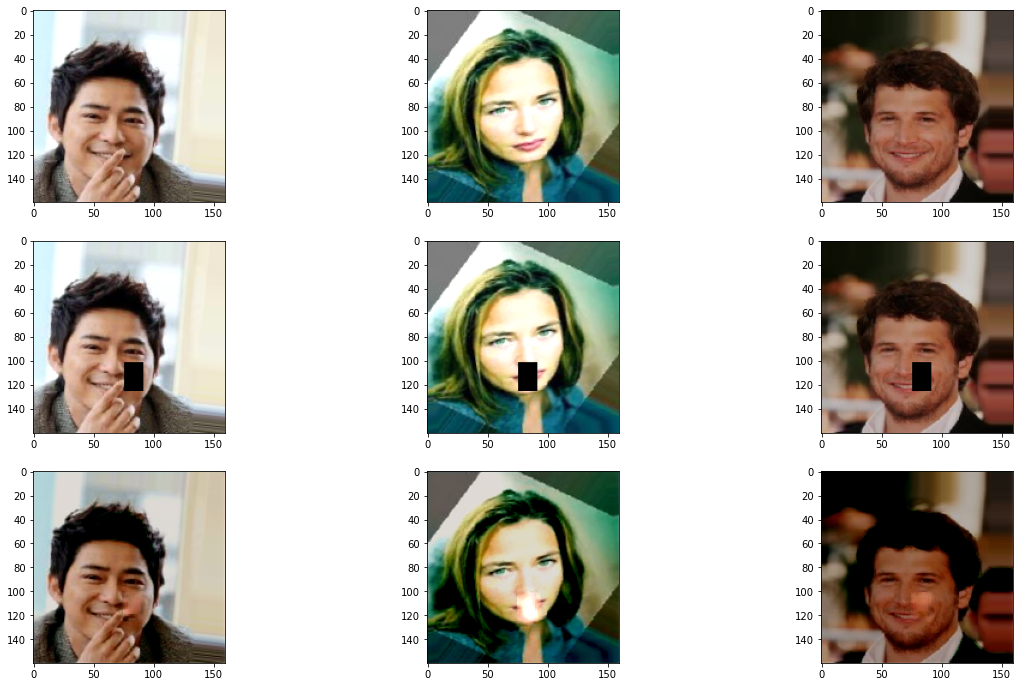


Plotting Results from the Validation Set:-


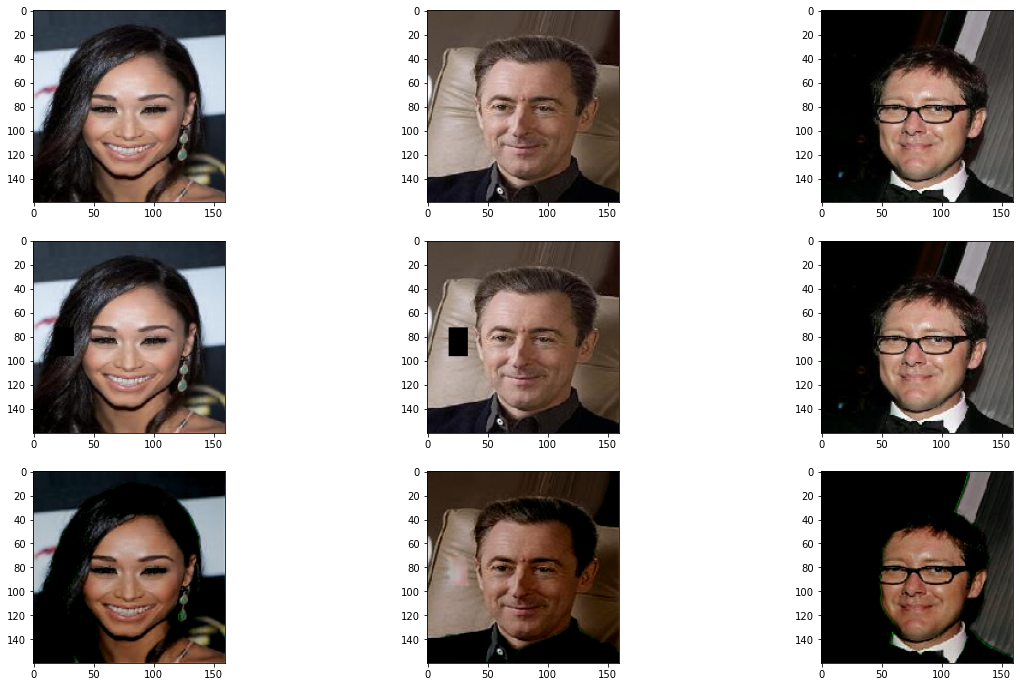

In [72]:
inference(img_sz=img_sz, bs=3)

# Saving the Model

In [28]:
generator.save("final_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: final_model\assets
